In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Standard libraries
import warnings

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow import keras

# Preprocessing
import preprocessor as pp

# Plotting
import plot_utils as pu

In [171]:
warnings.filterwarnings("ignore")

BATCH_SIZE = 2048

EPOCHS = 100

seed = 1227

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc",
    verbose=1,
    patience=10,  # Stop after 10 epochs without improvement
    mode="max",
    restore_best_weights=True,
)

## Data

In [4]:
train, test, validate = (
    pd.read_parquet("../data/train_val_test/train.parquet"),
    pd.read_parquet("../data/train_val_test/test.parquet"),
    pd.read_parquet("../data/train_val_test/validate.parquet"),
)
train.shape, test.shape, validate.shape

((182247, 31), (56959, 31), (45601, 31))

In [6]:
# Convert to tf.data.Dataset
train_ds = pp.df_to_dataset(train, shuffle=True, batch_size=BATCH_SIZE)
validate_ds = pp.df_to_dataset(validate, shuffle=True, batch_size=BATCH_SIZE)
test_ds = pp.df_to_dataset(test, shuffle=True, batch_size=BATCH_SIZE)

### Pipeline

In [7]:
# Containers for all inputs and encoded features
all_inputs = []
encoded_features = []

Log transform 'amount':

In [8]:
amount_col = keras.Input(shape=(1,), name="amount")
log_layer = keras.layers.Lambda(lambda x: tf.math.log(x + 1e-6))
transformed_amount = log_layer(amount_col)
all_inputs.append(amount_col)
encoded_features.append(transformed_amount)

Standardize numerical features:

In [9]:
for col in list(set(train.columns) - set(["class", "amount"])):
    numeric_col = keras.Input(shape=(1,), name=col)
    # Normalization layer
    normalizer = keras.layers.Normalization(axis=None)
    feature_ds = train_ds.map(lambda x, y: x[col])
    normalizer.adapt(feature_ds)
    # Transform 'col' and append to containers
    all_inputs.append(numeric_col)
    encoded_features.append(normalizer(numeric_col))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Define Model

We know the dataset is imbalanced, so we can set the output layer's bias to reflect that, which can help with initial convergence.

In [10]:
neg, pos = np.bincount(train["class"])
total = neg + pos
initial_bias = np.log([pos / neg])
initial_bias

array([-6.3524755])

We don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few positive examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [11]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.500871214203265, 1: 287.4558359621451}

Define the model using the Keras functional API.

In [13]:
metrics_list = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),  # ROC curve
    keras.metrics.AUC(name="prc", curve="PR"),  # Precision-recall curve
]

# Input pipeline
all_features = keras.layers.concatenate(encoded_features)  # Concatenate all features
x = keras.layers.Dense(units=16, activation="relu", name="dense_layer_1")(all_features)
x = keras.layers.Dropout(rate=0.5, name="dropout_layer_1")(x)
output = keras.layers.Dense(
    units=1,
    activation="sigmoid",
    bias_initializer=keras.initializers.Constant(value=initial_bias),
    name="output_layer",
)(x)

model = tf.keras.Model(all_inputs, output)

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics_list,
)

## Train Model using Class Weights

In [15]:
weighted_history = model.fit(
    x=train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=validate_ds,
    # The class weights go here
    class_weight=class_weight,
)

Epoch 1/100
89/89 [==============================] - 9s 57ms/step - loss: 1.1181 - tp: 139.0000 - fp: 4534.0000 - tn: 177396.0000 - fn: 178.0000 - accuracy: 0.9741 - precision: 0.0297 - recall: 0.4385 - auc: 0.7929 - prc: 0.0466 - val_loss: 0.0731 - val_tp: 52.0000 - val_fp: 625.0000 - val_tn: 44902.0000 - val_fn: 22.0000 - val_accuracy: 0.9858 - val_precision: 0.0768 - val_recall: 0.7027 - val_auc: 0.9451 - val_prc: 0.1235
Epoch 2/100
89/89 [==============================] - 6s 45ms/step - loss: 0.6688 - tp: 214.0000 - fp: 6757.0000 - tn: 175173.0000 - fn: 103.0000 - accuracy: 0.9624 - precision: 0.0307 - recall: 0.6751 - auc: 0.8725 - prc: 0.0926 - val_loss: 0.0896 - val_tp: 61.0000 - val_fp: 762.0000 - val_tn: 44765.0000 - val_fn: 13.0000 - val_accuracy: 0.9830 - val_precision: 0.0741 - val_recall: 0.8243 - val_auc: 0.9588 - val_prc: 0.1824
Epoch 3/100
89/89 [==============================] - 6s 42ms/step - loss: 0.5186 - tp: 238.0000 - fp: 8027.0000 - tn: 173903.0000 - fn: 79.0000 

In [19]:
# Write to disk
model.save("../outputs/models/weighted_model.h5")

## Evaluation Metrics

- **False negatives** and **false positives** are samples that were incorrectly classified
  
- **True negatives** and **true positives** are samples that were correctly classified
  
- **Accuracy** is the percentage of examples correctly classified $>\frac{\text { true samples }}{\text { total samples }}$
  
- **Precision** is the percentage of predicted positives that were correctly classified $>\frac{\text { true positives }}{\text { true positives }+\text { false positives }}$; the precision is intuitively the ability of the classifier not to label as positive a sample that is negative
  
- **Recall** is the percentage of actual positives that were correctly classified $>\frac{\text { true positives }}{\text { true positives }+\text { false negatives }}$; the recall is intuitively the ability of the classifier to find all the positive samples
  
- **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample
  
- **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

### Inference on Test Data

In [24]:
reloaded_model_weight = keras.models.load_model("../outputs/models/weighted_model.h5")
type(reloaded_model_weight)

keras.engine.functional.Functional

In [31]:
test_eval = reloaded_model_weight.evaluate(test_ds, workers=1, verbose=0)

In [32]:
{key: val for key, val in zip(reloaded_model_weight.metrics_names, test_eval)}

{'loss': 0.0769718587398529,
 'tp': 90.0,
 'fp': 808.0,
 'tn': 56050.0,
 'fn': 11.0,
 'accuracy': 0.9856212139129639,
 'precision': 0.10022271424531937,
 'recall': 0.8910890817642212,
 'auc': 0.9801710844039917,
 'prc': 0.5841116309165955}

### Predictions on Training and Test Data

Because we used `ds = ds.shuffle()` in the utility function to shuffle the dataset, the pipeline is non-deterministic. In order to compare the labels with the predictions in the right order, we have to use a for loop:

In [111]:
train_y = []
pred_y_train_weighted = []

for x, y in train_ds:
    train_y.append(y.numpy())
    pred_y_train_weighted.append(
        reloaded_model_weight(x, training=False).numpy().ravel()
    )

train_y = np.concatenate(train_y, axis=0)
pred_y_train_weighted = np.concatenate(pred_y_train_weighted, axis=0)

train_y.shape, pred_y_train_weighted.shape

((182247,), (182247,))

In [112]:
test_y = []
pred_y_test_weighted = []

for x, y in test_ds:
    test_y.append(y.numpy())
    pred_y_test_weighted.append(
        reloaded_model_weight(x, training=False).numpy().ravel()
    )

# Concatenate all predictions and labels
test_y = np.concatenate(test_y, axis=0)
pred_y_test_weighted = np.concatenate(pred_y_test_weighted, axis=0)

test_y.shape, pred_y_test_weighted.shape

((56959,), (56959,))

### Confusion Matrix

Legitimate Transactions Detected (True Negatives):  56050
Legitimate Transactions Incorrectly Detected (False Positives):  808
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  101


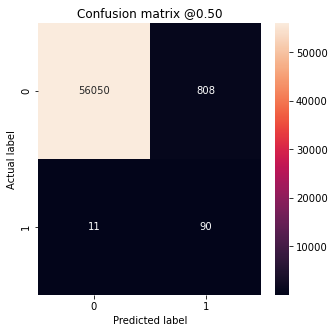

In [ ]:
pu.plot_cm(test_y, pred_y_test_weighted, p=0.5)

### Plot Metrics

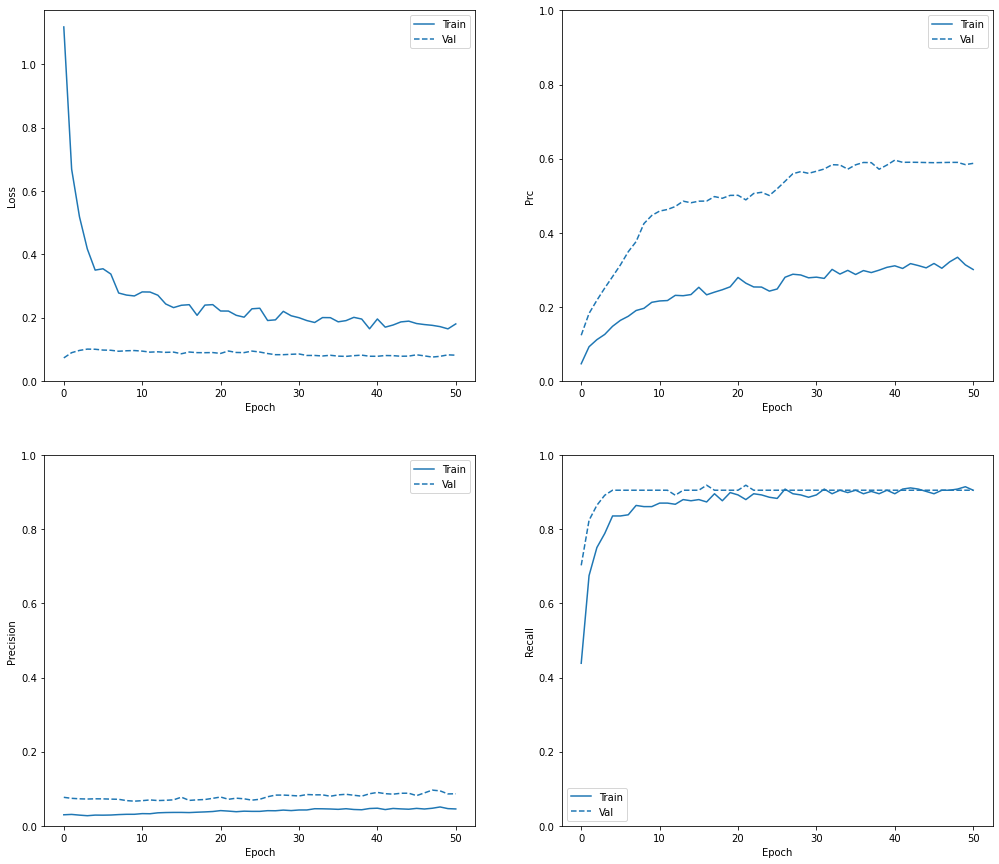

In [ ]:
plt.rcParams["figure.figsize"] = (17, 15)
pu.plot_metrics(weighted_history)

That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model. The `fit` method internally ensures that the dropout layer is not applied to the validation set.

### Plot ROC

The ROC curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.

* A skillful model will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. Generally, skillful models are represented by curves that bow up towards the top left of the plot.

* A no-skill classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A model with no skill at each threshold is represented by a diagonal line from the bottom left of the plot to the top right and has an AUC of 0.5.

<center> <img  src="../outputs/images/roc_curve.png" width="500" />   </center>

The worst AUROC is 0.5, and the best AUROC is 1.0.

* An AUROC of 0.5 (area under the red dashed line in the figure above) corresponds to a coin flip, i.e. a useless model
  
* An AUROC less than 0.7 is sub-optimal performance
  
* An AUROC of 0.70 – 0.80 is good performance

* An AUROC greater than 0.8 is excellent performance

* An AUROC of 1.0 (area under the purple line in the figure above) corresponds to a perfect classifier

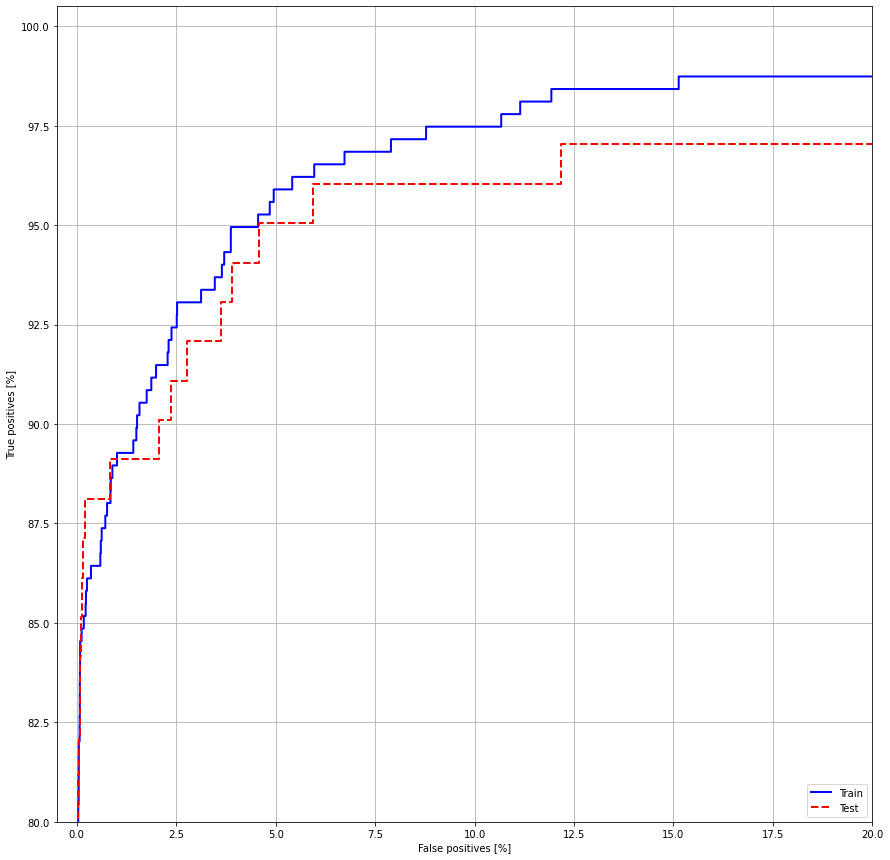

In [ ]:
pu.plot_roc("Train", train_y, pred_y_train_weighted, color="blue")
pu.plot_roc("Test", test_y, pred_y_test_weighted, color="red", linestyle="--")

plt.legend(loc="lower right");

### Plot AUPRC


Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision $(P)$ is defined as the number of true positives $\left(T_p\right)$ over the number of true positives plus the number of false positives ( $\left.F_p\right)$
$$
P=\frac{T_p}{T_p+F_p}
$$
Recall $(R)$ is defined as the number of true positives $\left(T_p\right)$ over the number of true positives plus the number of false negatives ( $\left.F_n\right)$
$$
R=\frac{T_p}{T_p+F_n}
$$
These quantities are also related to the $\left(F_1\right)$ score, which is defined as the harmonic mean of precision and recall.
$$
F 1=2 \frac{P \times R}{P+R}
$$
Note that the precision may not decrease with recall. The definition of precision $\left(\frac{T_p}{T_p+F_p}\right)$ shows that lowering the threshold of a classifier may increase the denominator, by increasing the number of results returned. If the threshold was previously set too high, the new results may all be true positives, which will increase precision. If the previous threshold was about right or too low, further lowering the threshold will introduce false positives, decreasing precision.

Recall is defined as $\frac{T_p}{T_p+F_n}$, where $T_p+F_n$ does not depend on the classifier threshold. This means that lowering the classifier threshold may increase recall, by increasing the number of true positive results. It is also possible that lowering the threshold may leave recall unchanged, while the precision fluctuates.

The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change in the threshold considerably reduces precision, with only a minor gain in recall.

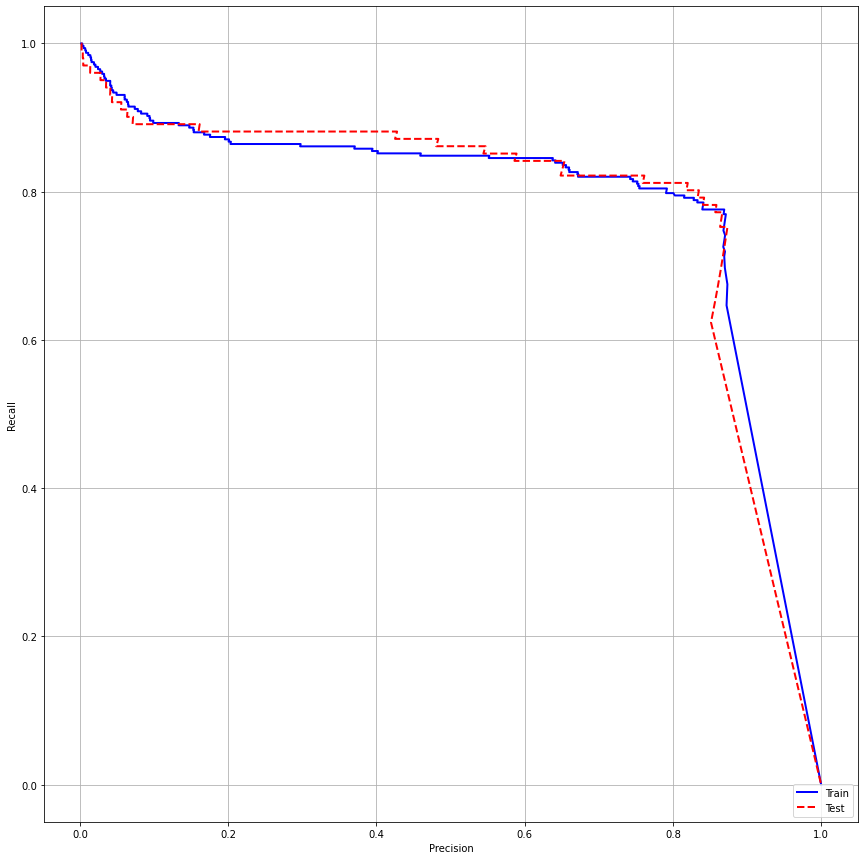

In [ ]:
pu.plot_prc("Train", train_y, pred_y_train_weighted, color="blue")
pu.plot_prc("Test", test_y, pred_y_test_weighted, color="red", linestyle="--")

plt.legend(loc="lower right");

## Model Inference on Unseen Data

In [250]:
random_sample = (
    test.apply(lambda x: x.sample(n=1, random_state=seed))
    .reset_index(drop=True)
    .to_dict()
)
random_sample

{'time': {0: 75725.0},
 'v1': {0: 1.223034914305},
 'v2': {0: 0.255391679696322},
 'v3': {0: -0.410596737981145},
 'v4': {0: 1.12171892558769},
 'v5': {0: 0.516017197375104},
 'v6': {0: 0.50240158016923},
 'v7': {0: -0.114661381480339},
 'v8': {0: 0.179935030526173},
 'v9': {0: 0.649593649317328},
 'v10': {0: -0.681341868529104},
 'v11': {0: -1.52545247016586},
 'v12': {0: -0.529348260511183},
 'v13': {0: -0.732257004819427},
 'v14': {0: -1.15584632739084},
 'v15': {0: 0.396959791515879},
 'v16': {0: 0.254131283078424},
 'v17': {0: 0.683874021145705},
 'v18': {0: 0.0948305131052544},
 'v19': {0: 0.0410383700263831},
 'v20': {0: -0.137748055391261},
 'v21': {0: -0.389798447125668},
 'v22': {0: -0.94940564264266},
 'v23': {0: -0.133084334393501},
 'v24': {0: -1.46027050506722},
 'v25': {0: 0.604900022941461},
 'v26': {0: -0.407596711149728},
 'v27': {0: 0.0606021512880488},
 'v28': {0: 0.0361158933844978},
 'amount': {0: 16.73},
 'class': {0: 0}}

In [260]:
# Convert input to tensor
input_dict = {
    name: tf.convert_to_tensor([value.get(0)]) for name, value in random_sample.items()
}
input_dict

{'time': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([75725.], dtype=float32)>,
 'v1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2230349], dtype=float32)>,
 'v2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2553917], dtype=float32)>,
 'v3': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.41059673], dtype=float32)>,
 'v4': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.1217189], dtype=float32)>,
 'v5': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5160172], dtype=float32)>,
 'v6': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5024016], dtype=float32)>,
 'v7': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.11466138], dtype=float32)>,
 'v8': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.17993502], dtype=float32)>,
 'v9': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.64959365], dtype=float32)>,
 'v10': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6813419], dtype=float32)>,
 'v11': <tf.Tensor: shape

In [261]:
# Predictions
prediction = reloaded_model_weight.predict(input_dict)

1/1 [==============================] - 1s 1s/step


In [274]:
print(
    f"This transaction has a {prediction.item() * 100:,.2f} percent probability of being fraudulent"
)

This transaction has a 12.42 percent probability of being fraudulent
